# Calculations for Sensor Calibration

Import standard data analysis, numerical comutation, and plotting libraries.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

Import the data.

In [2]:
df = pd.read_csv('data.csv', header=0)
df.columns = ['position', 'voltage']

Make a quick plot.

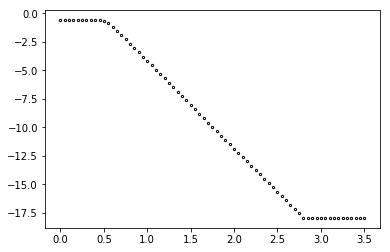

In [3]:
plt.scatter(df['position'], df['voltage'], s=5, c='w', edgecolor='k')
plt.show()

The __linear region__ appears to exten from 0.75 mm to 2.50 mm. We can get the exact bounds latter, but for now, lets just fit a linear calibration curve.

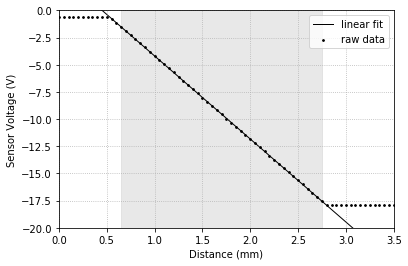

(-7.636933797909405, 3.442299651567946)

In [4]:
lb, ub = 0.65, 2.75

lr = df[(df['position'] > lb) & (df['position'] < ub)]

m, b = np.polyfit(lr['position'], lr['voltage'], 1)

x = np.linspace(lb - 0.5, ub + 0.5, 1000)

plt.scatter(df['position'], df['voltage'], s=3, c='k', label='raw data', zorder=2)
plt.plot(x, m * x + b, linewidth=1, color='black', linestyle='-', label='linear fit', zorder=1)
plt.axvspan(lb, ub, alpha=0.5, color='lightgrey', zorder=0)

plt.legend(loc='upper right')
plt.ylabel('Sensor Voltage (V)')
plt.xlabel('Distance (mm)')
plt.ylim((-20, 0))
plt.xlim((0, 3.5))
plt.grid(linestyle=':')

plt.savefig('linear', dpi=300)
plt.show()

m, b

Lets plot the residuals to get a better idea of how well our model fits.

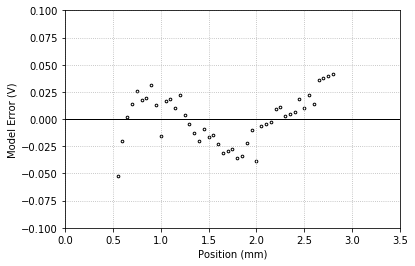

In [5]:
r = df['voltage'] - (m * df['position'] + b)

plt.scatter(df['position'], r, c='w', edgecolor='k', s=7)
plt.axhline(0, color='black', linewidth=1)

plt.grid(linestyle=':')

pm = 0.1
plt.ylim((-pm, pm))
plt.xlim((0, 3.5))

plt.ylabel('Model Error (V)')
plt.xlabel('Position (mm)')


plt.show()

The residuals do not appear to be normally distributed, let's try a couple polynomial fits.

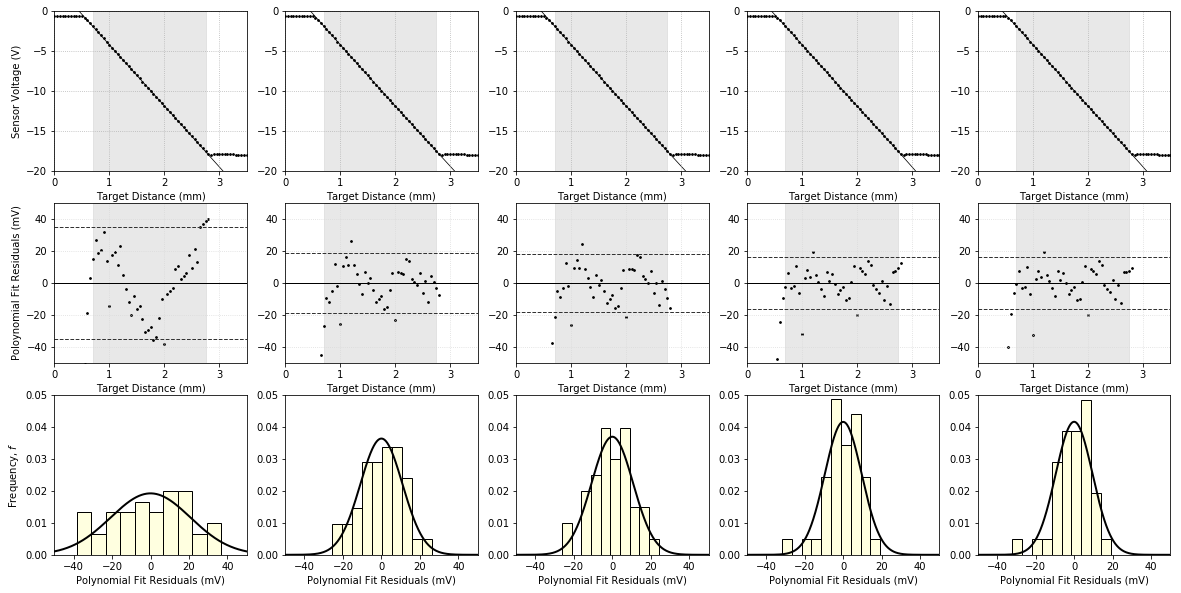

In [52]:
from scipy.stats import norm, t 

lb, ub = 0.70, 2.75
lr = df[(df['position'] > lb) & (df['position'] < ub)]

n = 5

fig, axes = plt.subplots(3, n, figsize=(4 * n, 10))

for i in range(n):
    f = np.poly1d(np.polyfit(lr['position'], lr['voltage'], i+1))
    x = np.linspace(lb - 0.5, ub + 0.5, 1000)

    axes[0, i].scatter(df['position'], df['voltage'], s=3, color='black', label='raw', zorder=2)
    axes[0, i].plot(x, f(x), linewidth=0.75, color='black', linestyle='-',label='fit', zorder=1)
    axes[0, i].axvspan(lb, ub, alpha=0.5, color='lightgrey', zorder=0)

    axes[0, i].set_ylim((-20, 0))
    axes[0, i].set_xlim((0, 3.5))
    axes[0, i].set_xlabel('Target Distance (mm)')
    axes[0, i].grid(linestyle=':')

    
    r   = df['voltage'] - f(df['position'])
    lrr = lr['voltage'] - f(lr['position'])
    
    alpha = 0.95
    v = lrr.size - 2
    
    CI = t.ppf(alpha, df=v) * sigma_d(lrr)

    axes[1, i].scatter(df['position'], r * 1000, color='black', s=3)
    axes[1, i].axhline(0, color='black', linewidth=1)
    axes[1, i].axhline(CI * 1000, color='0.20', linewidth=1, linestyle='--')
    axes[1, i].axhline(-CI * 1000, color='0.20', linewidth=1, linestyle='--')
    axes[1, i].axvspan(lb, ub, alpha=0.5, color='lightgrey', zorder=0)

    axes[1, i].grid(linestyle=':', c='0.85')
    axes[1, i].set_xlabel('Target Distance (mm)')

    pm = 50
    axes[1, i].set_ylim((-pm, pm))
    axes[1, i].set_xlim((0, 3.5))

    hist_min, hist_max = -50, 50
    x = np.linspace(hist_min, hist_max, 1000)
    r_lr = r[(df['position'] > lb) & (df['position'] < ub)] * 1000
    
    axes[2, i].hist(r_lr, color='lightyellow', edgecolor='black', normed=True)
    axes[2, i].plot(x, norm.pdf(x, loc=r_lr.mean(), scale=r_lr.std()), color='k', linewidth=2)
    axes[2, i].set_xlim((hist_min, hist_max))
    axes[2, i].set_ylim((0, 0.05))
    axes[2, i].set_xlabel('Polynomial Fit Residuals (mV)')
    
axes[0, 0].set_ylabel('Sensor Voltage (V)')
axes[1, 0].set_ylabel('Poloynomial Fit Residuals (mV)')
axes[2, 0].set_ylabel('Frequency, $f$')

fig.savefig('all_fits', dpi=300)
fig.show()

The quartic fit seems to be the lowest order polynomial fit that produces normally distributed residuals. We can find the parameters for that fit using `np.polyfit` again.

In [7]:
c = np.polyfit(lr['voltage'], lr['position'], 1)
f = np.poly1d(c)

r = f(lr['voltage']) - lr['position']
r = np.abs(r)

r.mean()

0.0023106881627187937

Lets determine the 2D Chauvenet's deviation for the fit.

$$
    \sigma _d = \sqrt{ \frac{\sum (\delta_i)^2}{(n-1)}}
$$

In [39]:
def sigma_d(x):
    x = np.asarray(x)
    
    n = x.size
    return np.sqrt((x * x).sum() / (n - 1))

Let's calculate the sample standard deviation.

In [9]:
sigma_d(r)

0.002719067323711185

We can then look up the critical deviation ratio based on sample size.

In [10]:
r.size

40

The critical deviation ratio is __2.98__, and we check for any samples that exceed the deviation ratio.

In [11]:
r[r / sigma_d(r) > 2.98]

Series([], Name: position, dtype: float64)

None are found.

In [12]:
z = (r - r.mean()) / r.std()

In [13]:
lr['zscore'] = z
lr['voltage_fit'] = f(lr['position'])
lr['delta'] = np.abs(lr['voltage_fit'] - lr['voltage'])
lr

/home/mmolter/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/mmolter/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/mmolter/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

,position,voltage,zscore,voltage_fit,delta
15,0.75,-2.26,0.846542,0.352335,2.612335
16,0.80,-2.65,0.071245,0.345787,2.995787
17,0.85,-3.03,0.241757,0.339239,3.369239
18,0.90,-3.40,1.358079,0.332691,3.732691
19,0.95,-3.80,-0.363027,0.326143,4.126143
20,1.00,-4.21,-0.307733,0.319595,4.529595
21,1.05,-4.56,-0.022002,0.313047,4.873047
22,1.10,-4.94,0.148510,0.306499,5.246499
23,1.15,-5.33,-0.626787,0.299952,5.629952
24,1.20,-5.70,0.489535,0.293404,5.993404


Now we can use the Student's t distribution to determine the 90% confidence interval of the quartic fit. The inteval is determined as follows.

$$
    V = C_4 x^4 + C_3 x^3 + C_2 x2 + C_1 x + C_0 \pm t(\alpha, \nu)\sigma_d
$$

The t value is.

In [14]:
from scipy.stats import t

alpha = 0.95
v = r.size - 2

t.ppf(alpha, df=v)

1.685954457643814

This leads to a fitting uncertainty of

In [15]:
CI = t.ppf(alpha, df=v) * sigma_d(r)

This can be plotted over the quartic fit.

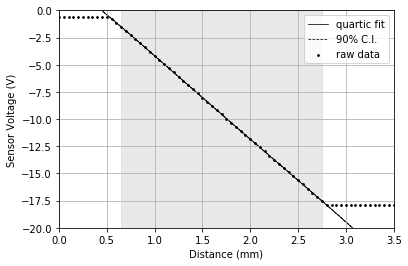

-0.066
0.471
-1.139
-6.559
3.115


In [16]:
lb, ub = 0.65, 2.75

lr = df[(df['position'] > lb) & (df['position'] < ub)]

C = np.polyfit(lr['position'], lr['voltage'], 4)
f = np.poly1d(C)

x = np.linspace(lb - 0.5, ub + 0.5, 1000)

plt.scatter(df['position'], df['voltage'], s=3, color='black', label='raw data', zorder=2)
plt.plot(x, f(x), linewidth=0.75, color='black', linestyle='-', label='quartic fit', zorder=1)
plt.plot(x, f(x) + CI, linewidth=0.75, color='black', linestyle='--', zorder=1, label='90% C.I.')
plt.plot(x, f(x) - CI, linewidth=0.75, color='black', linestyle='--', zorder=1)
plt.axvspan(lb, ub, alpha=0.5, color='lightgrey', zorder=0)

plt.legend(loc='upper right')
plt.ylabel('Sensor Voltage (V)')
plt.xlabel('Distance (mm)')
plt.ylim((-20, 0))
plt.xlim((0, 3.5))
plt.grid()

plt.savefig('quartic', dpi=300)
plt.show()

for i in C:
    print('{i:.3f}'.format(i=i))

The linearity of a sensor is the deviation from a straight line fit between the points at either end of the linear region.

In [31]:
x1 = 0.70
y1 = -1.89

x2 = 2.70
y2 = -17.14

xm = 1.70
ym = -9.57

m, b = np.polyfit([x1, x2], [y1, y2], 1)

fmy = m * xm + b


np.abs((fmy - ym) / (y2 - y1)) * 100

0.36065573770491616